# Cutting Sheet Goods

Cutting sheets goods into parts is a basic step in production of goods ranging from paper products, commercial and residential furniture, and textiles. The

In [1]:
# Import Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/mobook/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

In [24]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# random seed
#random.seed(1842)

# generate boxes
def generate_boxes(N, max_width=200, max_depth=200):
    boxes = pd.DataFrame()
    boxes["w"] = [random.randint(0.2*max_width, max_width) for i in range(N)]
    boxes["d"] = [random.randint(0.2*max_depth, max_depth) for i in range(N)]
    return boxes

N = 8
boxes = generate_boxes(8)
display(boxes)

# set shelf width as a multiple of the deepest box
D = 2*boxes["d"].max()
print("Shelf Depth = ", D)

,w,d
0,188,193
1,153,128
2,112,160
3,123,149
4,124,53
5,86,134
6,158,74
7,114,153


Shelf Depth =  386


In [25]:
def pack_boxes_V0(boxes):
    soln = boxes.copy()
    soln["x1"] = soln["w"].cumsum() - soln["w"]
    soln["x2"] = soln["w"].cumsum()
    soln["y1"] = 0
    soln["y2"] = soln["d"]
    return soln

pack_boxes_V0(boxes)

,w,d,x1,x2,y1,y2
0,188,193,0,188,0,193
1,153,128,188,341,0,128
2,112,160,341,453,0,160
3,123,149,453,576,0,149
4,124,53,576,700,0,53
5,86,134,700,786,0,134
6,158,74,786,944,0,74
7,114,153,944,1058,0,153


,w,d,x1,x2,y1,y2
0,188,193,0,188,0,193
1,153,128,188,341,0,128
2,112,160,341,453,0,160
3,123,149,453,576,0,149
4,124,53,576,700,0,53
5,86,134,700,786,0,134
6,158,74,786,944,0,74
7,114,153,944,1058,0,153


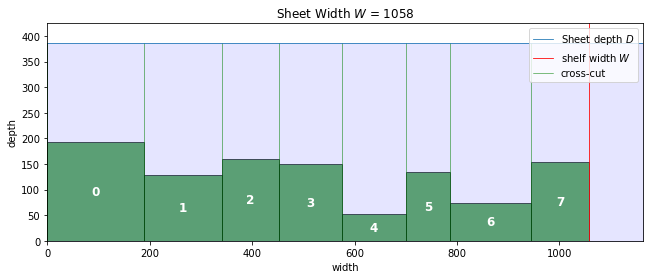

In [26]:
def show_boxes(soln, D):
    """Show bounding boxes on a diagram of the shelf."""
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    for i, x, y, w, h in zip(soln.index, soln["x1"], soln["y1"], soln["w"], soln["d"]):
        ax.add_patch(Rectangle((x, y), w, h, edgecolor="k", facecolor='g', alpha=0.6))
        xc = x + w/2
        yc = y + h/2
        ax.annotate(i, (xc, yc), color="w", weight="bold", fontsize=12, ha="center", va="center")
        ax.plot([x, x], [0, D], color='g', lw=0.5)
    ax.set_xlim(0, 1.1*soln["w"].sum())
    ax.set_ylim(0, D*1.1)
    ax.axhline(D, label="Sheet depth $D$", lw=0.8)
    ax.axvline(soln["x2"].max(), label="shelf width $W$", color="r", lw=0.8)
    ax.fill_between([0, ax.get_xlim()[1]], [D, D], color="b", alpha=0.1)
    ax.set_title(f"Sheet Width $W$ = {soln['x2'].max():.0f}")
    ax.set_xlabel("width")
    ax.set_ylabel("depth")
    ax.set_aspect('equal')
    ax.plot([0, 0], [0, D], color='g', lw=0.5, label="cross-cut")
    ax.legend(loc="upper right")
   
soln = pack_boxes_V0(boxes)
display(soln)
show_boxes(soln, D)

,w,d,x1,x2,y1,y2
0,188,193,89.0,277.0,264.0,457.0
1,153,128,89.0,242.0,133.0,261.0
2,112,160,280.0,392.0,308.0,468.0
3,123,149,280.0,403.0,0.0,149.0
4,124,53,89.0,213.0,0.0,53.0
5,86,134,0.0,86.0,0.0,134.0
6,158,74,89.0,247.0,56.0,130.0
7,114,153,280.0,394.0,152.0,305.0


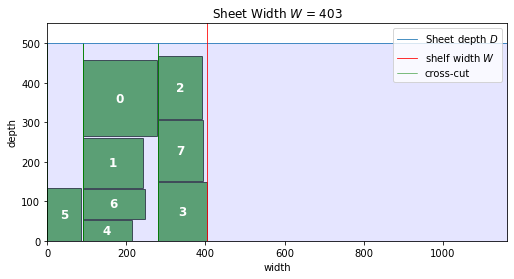

In [69]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def cut_sheet_goods(boxes, D, kerf=0):
    
    W_ub = boxes["w"].sum()

    m = pyo.ConcreteModel()
    
    m.D = pyo.Param(mutable=True, initialize=D)

    m.BOXES = pyo.Set(initialize=boxes.index)
    m.PAIRS = pyo.Set(initialize=m.BOXES * m.BOXES, filter=lambda m, i, j: i < j)
    m.CUTS = pyo.Set(initialize=boxes.index)
    
    m.W = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.y1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.y2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    
    m.cut = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))

    @m.Objective()
    def minimize_width(m):
        return m.W + 0.01*sum(m.y1[i] for i in m.BOXES)
    
    @m.Constraint(m.BOXES)
    def width(m, i):
        return m.x2[i] == m.x1[i] + boxes.loc[i, "w"]
    
    @m.Constraint(m.BOXES)
    def depth(m, i):
        return m.y2[i] == m.y1[i] + boxes.loc[i, "d"]
    
    @m.Constraint(m.BOXES)
    def max_width(m, i):
        return m.x2[i] <= m.W
    
    @m.Constraint(m.BOXES)
    def max_depth(m, i):
        return m.y2[i] <= m.D

    @m.Disjunction(m.PAIRS)
    def no_overlap(m, i, j):
        return [m.x2[i] + kerf <= m.x1[j],
                m.x2[j] + kerf <= m.x1[i],
                m.y2[i] + kerf <= m.y1[j],
                m.y2[j] + kerf <= m.y1[i]]
    
    @m.Disjunction(m.BOXES)
    def cross_cut(m, i):
        return [[m.x1[i] == m.cut[k]] for k in m.CUTS]
    
    @m.Disjunction(m.BOXES, m.CUTS, xor=True)
    def left_or_right(m, i, k):
        return [[m.x2[i] + kerf <= m.cut[k]], 
                [m.x1[i] >= m.cut[k]]]

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    solver = pyo.SolverFactory("gurobi_direct")
    solver.solve(m)

    soln = boxes.copy()
    soln["x1"] = [m.x1[i]() for i in boxes.index]
    soln["x2"] = [m.x2[i]() for i in boxes.index]
    soln["y1"] = [m.y1[i]() for i in boxes.index]
    soln["y2"] = [m.y2[i]() for i in boxes.index]

    return soln

D = 500

soln = cut_sheet_goods(boxes, D, 3)
display(soln)
show_boxes(soln, D)